In [1]:
# import the libraries as shown below
#transfer learning techinique where we can reuse the weights 

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50
#from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import preprocess_input # resenet50 is a neural network 
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

C:\Users\rinki\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\rinki\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\rinki\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\rinki\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:529: FutureWarning: Passi

In [2]:
from zipfile import ZipFile
with ZipFile('datasets.zip', 'r') as zf:
    zf.extractall()


In [3]:
# re-size all the images to this
IMAGE_SIZE = [224, 224]# any size can be given depends of type of images 

train_path = 'Datasets/train'
valid_path = 'Datasets/test'

In [4]:
# Import the Vgg 16 library as shown below and add preprocessing layer to the front of VGG
# Here we will be using imagenet weights

resnet = ResNet50(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)# y 3? because it is of 3 channels to make it RGV channel # we need three categories so we need not include first and last so it is false  

Instructions for updating:
Colocations handled automatically by placer.


C:\Users\rinki\anaconda3\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [5]:
resnet.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalizationV1) (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [6]:
# don't train existing weights
for layer in resnet.layers: #tranverse through each and every layer
    layer.trainable = False # false we dont train 

In [7]:
# useful for getting number of output classes
folders = glob('Datasets/train/*')

In [8]:
folders

['Datasets/train\\audi',
 'Datasets/train\\lamborghini',
 'Datasets/train\\mercedes']

In [9]:
len(folders)

3

In [10]:
# our layers - you can add more if you want
x = Flatten()(resnet.output)#flattening the output

In [11]:
prediction = Dense(len(folders), activation='softmax')(x) #dense layer with 3 nodes 

# create a model object
model = Model(inputs=resnet.input, outputs=prediction)

In [12]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalizationV1) (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [13]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [14]:
# Use the Image Data Generator to import the images from the dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator #data augumentation  can be done by imagedatagenerator 

train_datagen = ImageDataGenerator(rescale = 1./255, # to use ImageDataGenerator we need to scale down the values 
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [15]:
# Make sure you provide the same target size as initialied for the image size
training_set = train_datagen.flow_from_directory('Datasets/train',
                                                 target_size = (224, 224), # should be same the inialized in the model 
                                                 batch_size = 32,
                                                 class_mode = 'categorical') #if more than 2 clses we should use catergorial and less than 3 then binary

Found 64 images belonging to 3 classes.


In [16]:
test_set = test_datagen.flow_from_directory('Datasets/test',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 58 images belonging to 3 classes.


In [17]:
# fit the model
# Run the cell. It will take some time to execute
r = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=100,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

Instructions for updating:
Use tf.cast instead.
Epoch 1/100
2/2 [==============================] - 40s 20s/step - loss: 4.2772 - acc: 0.4219 - val_loss: 9.4114 - val_acc: 0.3276
Epoch 2/100
2/2 [==============================] - 41s 21s/step - loss: 6.0049 - acc: 0.5781 - val_loss: 10.8417 - val_acc: 0.3276
Epoch 3/100
2/2 [==============================] - 40s 20s/step - loss: 4.6280 - acc: 0.6875 - val_loss: 11.1587 - val_acc: 0.3276
Epoch 4/100
2/2 [==============================] - 41s 20s/step - loss: 5.3023 - acc: 0.6562 - val_loss: 10.8681 - val_acc: 0.3276
Epoch 5/100
2/2 [==============================] - 40s 20s/step - loss: 4.9973 - acc: 0.6562 - val_loss: 10.7519 - val_acc: 0.3276
Epoch 6/100
2/2 [==============================] - 39s 20s/step - loss: 4.2319 - acc: 0.7344 - val_loss: 10.8100 - val_acc: 0.3276
Epoch 7/100
2/2 [==============================] - 40s 20s/step - loss: 4.5444 - acc: 0.7031 - val_loss: 10.8100 - val_acc: 0.3276
Epoch 8/100
2/2 [===================

In [20]:
r.history

{'loss': [4.277229070663452,
  6.004865884780884,
  4.627993106842041,
  5.302313804626465,
  4.997298002243042,
  4.231896281242371,
  4.544396638870239,
  4.820911407470703,
  4.609843492507935,
  4.783109664916992,
  4.040639400482178,
  4.281371831893921,
  4.110368371009827,
  4.4938740730285645,
  3.7776790857315063,
  4.173400163650513,
  4.029523849487305,
  3.724307060241699,
  3.777678608894348,
  3.2956778705120087,
  1.5576672554016113,
  0.27581050153821707,
  1.267357736825943,
  0.7762688398361206,
  0.4798414185643196,
  0.9008205980062485,
  0.39709044992923737,
  0.2520096004009247,
  1.1920928955078125e-07,
  0.2518485486507416,
  0.13216696679592133,
  0.003784372704103589,
  0.32128705084323883,
  1.2386590242385864e-07,
  0.08745261281728745,
  1.1920928955078125e-07,
  1.2414732282195473e-06,
  1.1920928955078125e-07,
  0.007617614232003689,
  1.1920928955078125e-07,
  1.1920928955078125e-07,
  1.1920928955078125e-07,
  6.891891644045245e-07,
  7.199239462352125e

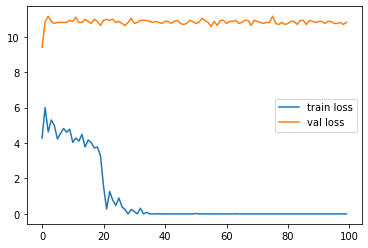

KeyError: 'accuracy'

<Figure size 432x288 with 0 Axes>

In [24]:
# plot the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [25]:
# save it as a h5 file


from tensorflow.keras.models import load_model

model.save('model_resnet50.h5')

In [26]:
y_pred = model.predict(test_set)

In [27]:
y_pred

array([[2.70157643e-15, 2.45565496e-19, 1.00000000e+00],
       [1.07538795e-15, 1.30535884e-18, 1.00000000e+00],
       [6.65902257e-16, 2.60345378e-18, 1.00000000e+00],
       [1.61290807e-15, 4.26097923e-19, 1.00000000e+00],
       [1.72563841e-15, 3.78160903e-17, 1.00000000e+00],
       [1.67165309e-15, 4.13563707e-19, 1.00000000e+00],
       [9.39104899e-16, 1.65997003e-19, 1.00000000e+00],
       [1.23970599e-15, 9.08593693e-19, 1.00000000e+00],
       [2.53070342e-15, 3.92226971e-19, 1.00000000e+00],
       [4.82718783e-16, 1.44321963e-19, 1.00000000e+00],
       [2.26234623e-15, 2.56200480e-19, 1.00000000e+00],
       [5.44753782e-15, 3.80409114e-18, 1.00000000e+00],
       [1.04670847e-15, 1.08225009e-19, 1.00000000e+00],
       [1.99864708e-15, 7.57417079e-19, 1.00000000e+00],
       [5.92573080e-16, 3.10532830e-19, 1.00000000e+00],
       [1.11792795e-15, 1.16654555e-19, 1.00000000e+00],
       [5.79863043e-15, 9.74711790e-19, 1.00000000e+00],
       [9.81024877e-16, 2.68360

In [28]:
import numpy as np
y_pred = np.argmax(y_pred, axis=1)

In [29]:
y_pred

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int64)

In [30]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

In [31]:
model=load_model('model_resnet50.h5')

In [34]:
model

In [35]:
img=image.load_img('Datasets/Test/lamborghini/11.jpg',target_size=(224,224))

In [37]:
image

<module 'tensorflow.keras.preprocessing.image' from 'C:\\Users\\rinki\\anaconda3\\lib\\site-packages\\tensorflow\\_api\\v1\\keras\\preprocessing\\image\\__init__.py'>

In [38]:
x=image.img_to_array(img)

In [39]:
x

array([[[252., 252., 252.],
        [252., 252., 252.],
        [252., 252., 252.],
        ...,
        [196., 187., 172.],
        [217., 208., 193.],
        [243., 234., 219.]],

       [[252., 252., 252.],
        [252., 252., 252.],
        [252., 252., 252.],
        ...,
        [245., 245., 237.],
        [243., 243., 235.],
        [242., 242., 234.]],

       [[252., 252., 252.],
        [252., 252., 252.],
        [252., 252., 252.],
        ...,
        [240., 249., 248.],
        [242., 251., 250.],
        [242., 251., 250.]],

       ...,

       [[189., 207., 229.],
        [190., 206., 229.],
        [190., 206., 229.],
        ...,
        [171., 180., 187.],
        [171., 180., 187.],
        [171., 180., 187.]],

       [[185., 206., 227.],
        [185., 206., 227.],
        [185., 206., 227.],
        ...,
        [171., 180., 187.],
        [171., 180., 187.],
        [171., 180., 187.]],

       [[185., 206., 227.],
        [185., 206., 227.],
        [185., 2

In [40]:
x.shape

(224, 224, 3)

In [43]:
x=x/225
x

array([[[[-0.5447111 , -0.51404   , -0.45697334],
         [-0.5447111 , -0.51404   , -0.45697334],
         [-0.5447111 , -0.51404   , -0.45697334],
         ...,
         [-0.5458173 , -0.51532394, -0.4585536 ],
         [-0.54540247, -0.51490915, -0.45813876],
         [-0.54488885, -0.51439553, -0.45762518]],

        [[-0.5447111 , -0.51404   , -0.45697334],
         [-0.5447111 , -0.51404   , -0.45697334],
         [-0.5447111 , -0.51404   , -0.45697334],
         ...,
         [-0.5448494 , -0.5141783 , -0.45726964],
         [-0.54488885, -0.5142178 , -0.45730916],
         [-0.54490864, -0.5142375 , -0.4573289 ]],

        [[-0.5447111 , -0.51404   , -0.45697334],
         [-0.5447111 , -0.51404   , -0.45697334],
         [-0.5447111 , -0.51404   , -0.45697334],
         ...,
         [-0.54494816, -0.51409924, -0.45705238],
         [-0.54490864, -0.5140598 , -0.45701283],
         [-0.54490864, -0.5140598 , -0.45701283]],

        ...,

        [[-0.5459556 , -0.5149289 , -0

In [42]:
x=np.expand_dims(x,axis=0)
img_data=preprocess_input(x)
img_data.shape

(1, 224, 224, 3)

In [44]:
model.predict(img_data)

array([[5.0615530e-08, 1.8894683e-11, 1.0000000e+00]], dtype=float32)

In [45]:
a=np.argmax(model.predict(img_data), axis=1)

In [46]:
a

array([2], dtype=int64)